In [1]:
import sys, getopt, re

def main(argv):
    inputfile = ''
    try:
        opts, args = getopt.getopt(argv,"i:")
        # print(opts,args)
    except getopt.GetoptError:
        print('TopicClassifier.py -i <BRAND>')
        sys.exit(2)
    
    for opt, arg in opts:
        if opt == "-i":
            inputfile = arg
    
    if len(inputfile)==0:
        print('usage: TopicClassifier.py -i <BRAND>')
        sys.exit(2)
    print('Input BRAND is ', inputfile)
    return inputfile

In [2]:
BRAND      = 'HAIRCARE'

---

In [3]:
from fastai.text import * # Quick access to NLP functionality

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [5]:
import pickle

# Pre-Processing

## Data Loading (from saved verbatim)

In [6]:
dirname = './data/excels/'

df=1; del df
for filename in os.listdir(dirname):
    df_tmp = pd.read_excel(os.path.join(dirname, filename), header=None, skiprows=1)
    df_tmp['topic'] = filename.split('Aspect_')[-1].replace('_2.xls','')
    
    try:
        df = pd.concat([df,df_tmp])
    except:
        df = df_tmp.copy()

df.head()

,0,1,2,3,4,5,6,7,8,topic
0,"I could see tons of dandruff, but the itching ...",Dove Derma Care Scalp Dryness & Itch Relief An...,4.0,My scalp was so itchy I was convinced I must h...,1,Positive,11/10/2018,TARGET.COM,https://www.target.com/p/dove-derma-care-scalp...,Weather
1,The flakes are gone but the itching and sores ...,Head & Shoulders 2 Piece Clinical Solutions Sh...,5.0,Best I’ve ever used. I used to have severe dan...,1,Positive,10/26/2018,AMZ,https://www.amazon.com/Head-Shoulders-Clinical...,Weather
2,In warm weather my fine hair does seem more dr...,Dove Dermacare Scalp Anti-Dandruff Shampoo Dry...,5.0,Thank you for your entire line of Dermacare ha...,1,Positive,9/23/2018,-,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Weather
3,This product always cures my itch during dry w...,Head & Shoulders Volume Boost Hair Shampoo - 1...,4.0,This product always cures my itch during dry w...,1,Positive,9/12/2018,TARGET.COM,https://www.target.com/p/head-shoulders-volume...,Weather
4,Great shampoo for the winter!,Head & Shoulders Volume Boost Hair Shampoo - 1...,5.0,Great shampoo for the winter! l use it around ...,1,Positive,9/5/2018,TARGET.COM,https://www.target.com/p/head-shoulders-volume...,Weather


## Data Cleaning

Extract the text snippets and associated topic; remove duplicates and too short verbatum 

In [7]:
# only keep snippets
df = df[[0,'topic']].rename(columns = {0:'text', 'topic':'label'})

# enforce format
df['text'] = df['text'].astype(str)

# remove short comments (keep 2nd percentile and higher lenghts)
thresh = df['text'].apply(len).quantile(0.02)

df = df.loc[df['text'].apply(lambda x: len(x)>=thresh)].\
    drop_duplicates()

In [8]:
# keep only topics with enough samples
df_counts = df.groupby('label').size()
df = df.loc[df.label.isin(df_counts[df_counts>df_counts.max()/100].index.tolist())]

In [9]:
# reset index
df = df.reset_index().drop('index', axis=1)

## Pre-Tokenization

In [10]:
# # Setup stop words
# from spacy.lang.en.stop_words import STOP_WORDS

# for word in STOP_WORDS:
#     for w in (word, word[0].capitalize(), word.upper()):
#         lex = nlp.vocab[w]
#         lex.is_stop = True

In [11]:
# from nltk.corpus import stopwords
import spacy
import string

# stop = set(stopwords.words('english'))
exclude = set(string.punctuation)-set(['!','?'])

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

def preprocess(doc, tags=['NOUN', 'ADJ','VERB','ADV']):
    # make entire text lower case
    doc = doc.lower()    
    
    # replace "n't" with " not" & remove unwanted characters, numbers and symbols
    doc = doc.replace("n\'t", " not").replace("[^a-zA-Z#]", " ")
       
    # remove stop words
    # doc = " ".join([i for i in doc.split() if i not in stop])
    
    # remove short words (length < 3)
    # doc = " ".join([r for r in doc.split() if len(r)>2])
    
    # remove punctuation
    doc = ''.join(ch for ch in doc if ch not in exclude)
    
    # lemmatization
    doc = " ".join([token.lemma_ for token in nlp(doc) if token.pos_ in tags])
    return doc

In [12]:
# removes stop words, short words, and punctuation; lowercase and lemmatize all
print(' Pre-Tokenization')
df['text']        = df['text'].apply(preprocess)

 Pre-Tokenization


# Semantic Similarity

In [13]:
path = './'

path = Path('./')

Load embeddings matrix

In [14]:
with open('./models/fastai_nlp/embedding_mtx.pickle', 'rb') as handle:
    emb_mtx = pickle.load(handle) 

Load the language model:

In [15]:
with open('./models/fastai_nlp/vocab_{:}.pkl'.format(BRAND), 'rb') as handle:
    vocab = pickle.load(handle)

Tokenize verbatum

In [16]:
stoi = []
for idx,row in df.iterrows(): 
    posx = list(set(vocab.numericalize(row['text'].split())))
    vct = np.zeros(emb_mtx.shape[0])
    vct[posx]=1
    
    stoi.append(vct)

verbatum_embeddings = np.dot(np.vstack(stoi),emb_mtx)

Tokenize reference

In [26]:
df_ref = pd.read_csv('./data/haircare_codes.csv')
df_ref['comment'] = df_ref['comment'].apply(lambda x: x.lower().replace('//',' ').replace('/',' '))
df_ref['comment'] = df_ref['comment'].apply(preprocess)
df_ref.head()

,comment,aspect,sentiment
0,hair look feel soft,HAIR CONDITION,1
1,soften hair hair not feel stiff coarse,HAIR CONDITION,1
2,leaf hair shiny bright,HAIR CONDITION,1
3,give hair more sheen not dull hair give hair h...,HAIR CONDITION,1
4,prevent hair be dry replace put moisture hair,HAIR CONDITION,1


In [27]:
stoi = []
for idx,row in df_ref.iterrows(): 
    posx = list(set(vocab.numericalize(preprocess(row['comment']).split())))
    vct = np.zeros(emb_mtx.shape[0])
    vct[posx]=1
    
    stoi.append(vct)

verbatum_embeddings_ref = np.dot(np.vstack(stoi),emb_mtx)

In [28]:
from numpy import linalg as LA

# normalize both vectors
verbatum_embeddings     = verbatum_embeddings    /LA.norm(verbatum_embeddings    , axis=1)[:,np.newaxis]
verbatum_embeddings_ref = verbatum_embeddings_ref/LA.norm(verbatum_embeddings_ref, axis=1)[:,np.newaxis]

Visualize the data

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
output_r = pca.fit_transform(verbatum_embeddings)

In [30]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.078816 0.064998]


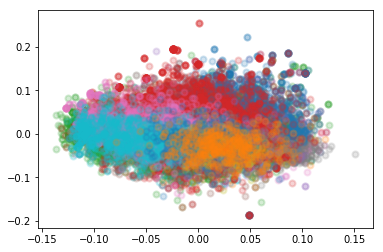

In [31]:
lw = 2

for i, target_name in enumerate(df.label.unique()):
    pos = (df.label==target_name).values
    plt.scatter(output_r[pos, 0], output_r[pos, 1], alpha=.2, lw=lw,
                label=target_name)

In [21]:
from scipy.spatial import distance

In [32]:
corr = np.zeros((verbatum_embeddings.shape[0],verbatum_embeddings_ref.shape[0]))
for idx1 in range(verbatum_embeddings.shape[0]):
    for idx2 in range(verbatum_embeddings_ref.shape[0]):
        corr[idx1,idx2] = np.corrcoef(verbatum_embeddings[idx1,:], verbatum_embeddings_ref[idx2,:])[0, 1]
    #sim.append(1 - distance.cosine(verbatum_embeddings[idx1,:], verbatum_embeddings_ref[idx2,:]))

In [33]:
idx1 = 4523
idx2 = np.argsort(corr[idx1,:])

In [34]:
df.iloc[idx1].values

array(['product have also start help -PRON- son as well have very dry scalp have start use have notice -PRON- hair look way more healthy even have silky look be longer dry',
       'Nutrition & Hair Health'], dtype=object)

In [36]:
# df_emb['aspect'].iloc[idx2]
df_ref.iloc[idx2].head()

,comment,aspect,sentiment
360,price,ECONOMY,0
102,dandruff flake,SCALP DANDRUFF,1
303,dandruff flake,DANDRUFF,0
198,specific version,MISCELLANEOUS,1
173,leakproof closure,PACKAGE/BOTTLE/CONTAINER,1
